<a href="https://colab.research.google.com/github/adiletamangossov/DataAnalysis_portfolio/blob/main/NLP_with_disaster_tweets_using_BERTmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers datasets torch scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
if torch.cuda.is_available():
    print("CUDA is available. Using GPU:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU: Tesla T4


In [4]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [5]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
# splitting to train and val
train_texts, val_texts, train_labels, val_labels = train_test_split(train_data.text, train_data.target, test_size=0.2, random_state=42)

In [8]:
# initializing tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# tokenizing our input data
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128, return_tensors="pt")
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128, return_tensors="pt")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [9]:
train_encodings.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [10]:
train_encodings.input_ids.shape

torch.Size([6090, 84])

In [11]:
train_encodings.token_type_ids

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [12]:
train_encodings.attention_mask[0]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [13]:
train_encodings.attention_mask[1]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [14]:
train_encodings.attention_mask[4345]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [15]:
# transforming target data to tensors
train_labels = torch.tensor(list(train_labels))
val_labels = torch.tensor(list(val_labels))

In [16]:
from torch.utils.data import Dataset

# creating Dataset
class DisasterDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

# Creating Dataset objs
train_dataset = DisasterDataset(train_encodings, train_labels)
val_dataset = DisasterDataset(val_encodings, val_labels)

# Creating DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [17]:
# Init BERT with classify
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# using gpu if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [18]:
# optimizer
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

# loss func
loss_fn = torch.nn.CrossEntropyLoss()

# storage for metrics
train_losses = []
val_losses = []
f1_scores = []

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: AVG Loss on training: 0.1819, AVG Loss on val: 0.4472, F1 Score: 0.7974
Epoch 2: AVG Loss on training: 0.1834, AVG Loss on val: 0.4472, F1 Score: 0.7974


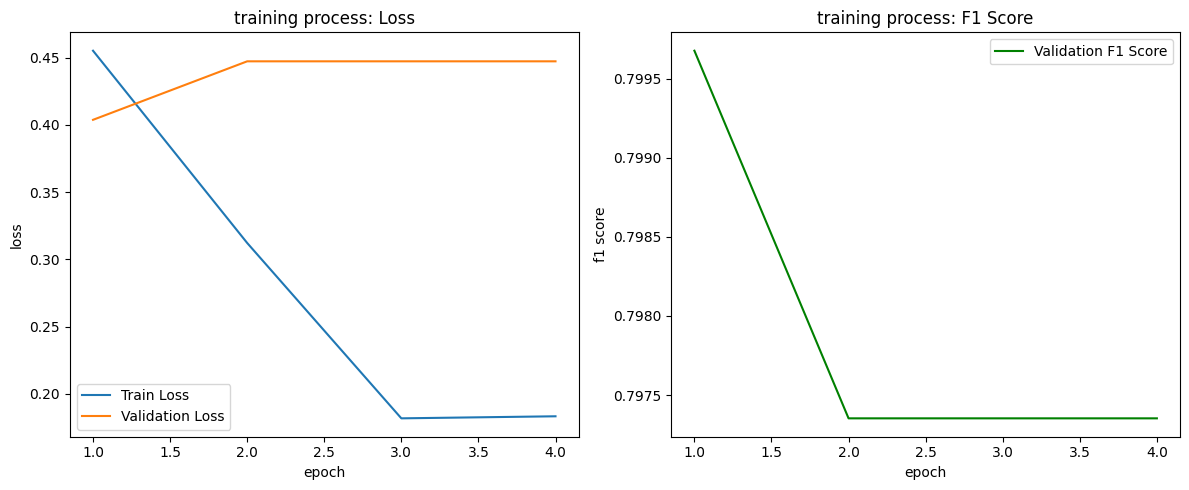

In [24]:
# training...
for epoch in range(2):
    model.train()
    total_loss = 0

    for batch in train_loader:
        inputs = {key: val.to(device) for key, val in batch.items()}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_losses.append(total_loss / len(train_loader))

    # eval on valid data with f1 score
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            inputs = {key: val.to(device) for key, val in batch.items()}
            outputs = model(**inputs)
            logits = outputs.logits
            val_loss += outputs.loss.item()
            preds = torch.argmax(logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(batch["labels"].cpu().numpy())

    val_losses.append(val_loss / len(val_loader))
    f1 = f1_score(true_labels, predictions)
    f1_scores.append(f1)

    print(f"Epoch {epoch + 1}: AVG Loss on training: {train_losses[-1]:.4f}, AVG Loss on val: {val_losses[-1]:.4f}, F1 Score: {f1:.4f}")


# Visualizing
plt.figure(figsize=(12, 5))

# Loss graph
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("training process: Loss")
plt.legend()

# F1-graph
plt.subplot(1, 2, 2)
plt.plot(range(1, len(f1_scores) + 1), f1_scores, label="Validation F1 Score", color="green")
plt.xlabel("epoch")
plt.ylabel("f1 score")
plt.title("training process: F1 Score")
plt.legend()

plt.tight_layout()
plt.show()


## Predicting on test data

In [25]:
new_test_data = dict(test_data[["id", "text"]].values)

In [26]:
ids = list(new_test_data.keys())
texts = list(new_test_data.values())

In [27]:
# Tokenizing
new_encodings = tokenizer(
    texts,
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors="pt"
)

# transfering data to device (GPU/CPU)
new_encodings = {key: val.to(device) for key, val in new_encodings.items()}

In [28]:
# taking predictions
model.eval()
with torch.no_grad():
    outputs = model(**new_encodings)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1).cpu().numpy()

In [43]:
# forming result
results = [{"id": id_, "target": int(pred)} for id_, pred in zip(ids, predictions)]



In [44]:

# printing the result
print("Prediction results:")
results = pd.DataFrame(results)
results.head()


Prediction results:


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [45]:
# Saving the result
pd.DataFrame(results).to_csv("predictions.csv", index=False)

In [47]:
results.target.value_counts()

,count
target,
0,2102
1,1161
